In [1]:
!pip install tensorboard pandas
!pip install matplotlib seaborn


/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/bin/python -m pip install --upgrade pip' command.
/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/bin/python -m pip install --upgrade pip' command.


In [2]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

In [3]:
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)


TensorBoard version:  2.5.0


In [4]:
def convert_tb_data(root_dir, sort_by=None):
    """Convert local TensorBoard data into Pandas DataFrame.
    
    Function takes the root directory path and recursively parses
    all events data.    
    If the `sort_by` value is provided then it will use that column
    to sort values; typically `wall_time` or `step`.
    
    *Note* that the whole data is converted into a DataFrame.
    Depending on the data size this might take a while. If it takes
    too long then narrow it to some sub-directories.
    
    Paramters:
        root_dir: (str) path to root dir with tensorboard data.
        sort_by: (optional str) column name to sort by.
    
    Returns:
        pandas.DataFrame with [wall_time, name, step, value] columns.
    
    """
    import os
    import pandas as pd
    from tensorflow.python.summary.summary_iterator import summary_iterator

    def convert_tfevent(filepath):
        return pd.DataFrame([
            parse_tfevent(e) for e in summary_iterator(filepath) if len(e.summary.value)
        ])

    def parse_tfevent(tfevent):
        return dict(
            wall_time=tfevent.wall_time,
            name=tfevent.summary.value[0].tag,
            step=tfevent.step,
            value=float(tfevent.summary.value[0].simple_value),
        )
    
    columns_order = ['wall_time', 'name', 'step', 'value']
    
    out = []
    for (root, _, filenames) in os.walk(root_dir):
        for filename in filenames:
            if "events.out.tfevents" not in filename:
                continue
            file_full_path = os.path.join(root, filename)
            out.append(convert_tfevent(file_full_path))

    # Concatenate (and sort) all partial individual dataframes
    all_df = pd.concat(out)[columns_order]
    if sort_by is not None:
        all_df = all_df.sort_values(sort_by)
        
    return all_df.reset_index(drop=True)

In [25]:
dir_path = "/fsx/code/gradstats/BERT/results/pretrain_large_4node_adam_grad_clipping_2norm_1_monitoring/tensorboard_phase1/bert_training"
exp_name = "worker-0"
df = convert_tb_data(f"{dir_path}/{exp_name}")

print(df.head())

      wall_time                   name  step         value
0  1.635898e+09  Train/Real Iterations     1  1.000000e+00
1  1.635898e+09             Train/Loss     1  1.127476e+01
2  1.635898e+09    Train/Learning Rate     1  3.410169e-10
3  1.635898e+09             Train/Gain     1  1.000000e+00
4  1.635898e+09              Train/GNS     1  0.000000e+00


In [26]:
df

,wall_time,name,step,value
0,1.635898e+09,Train/Real Iterations,1,1.000000e+00
1,1.635898e+09,Train/Loss,1,1.127476e+01
2,1.635898e+09,Train/Learning Rate,1,3.410169e-10
3,1.635898e+09,Train/Gain,1,1.000000e+00
4,1.635898e+09,Train/GNS,1,0.000000e+00
...,...,...,...,...
318269,1.636049e+09,Train/weight_key_Inf_norm,4301,0.000000e+00
318270,1.636049e+09,Train/weight_value_Inf_norm,4301,0.000000e+00
318271,1.636049e+09,Train/weight_dense_act_Inf_norm,4301,0.000000e+00
318272,1.636049e+09,Train/weight_LayerNorm_act_Inf_norm,4301,0.000000e+00


In [27]:
grouped_df = df.groupby('name')

In [28]:

grouped_df_lst = grouped_df["value"].apply(list)

grouped_df_lst = grouped_df_lst.reset_index()



In [29]:
grouped_df_lst.head()

,name,value
0,Train/Effective LR,"[3.410168536444047e-10, 1.3640674145776188e-09..."
1,Train/GNS,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Train/Gain,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,Train/Learning Rate,"[3.410168536444047e-10, 1.3640674145776188e-09..."
4,Train/Loss,"[11.274764060974121, 11.280522346496582, 11.27..."


In [30]:
grouped_df_lst

,name,value
0,Train/Effective LR,"[3.410168536444047e-10, 1.3640674145776188e-09..."
1,Train/GNS,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Train/Gain,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,Train/Learning Rate,"[3.410168536444047e-10, 1.3640674145776188e-09..."
4,Train/Loss,"[11.274764060974121, 11.280522346496582, 11.27..."
...,...,...
69,Train/weight_layer_8_2norm,"[82.25440979003906, 82.25440979003906, 82.2544..."
70,Train/weight_layer_9_2norm,"[82.26065063476562, 82.26065063476562, 82.2606..."
71,Train/weight_pooler_2norm,"[18.48503303527832, 18.48503303527832, 18.4850..."
72,Train/weight_query_Inf_norm,"[0.1113998219370842, 0.1113998219370842, 0.111..."


In [65]:
def find_first_nan_index(row):
    value_list = row['value']
    from math import isnan
    for i in range(len(value_list)):
        if isnan(value_list[i]):
            return i
    return i
        
#    return lst.index(next(filter(lambda x:  isnan(x), lst)))

In [66]:
lst = [1.0,0, 3, float('nan'), float('nan'), 5.5, 5.0, 5.0, 5.5, 6.0, 6.5]
find_first_nan_index('junk',lst)

TypeError: find_first_nan_index() takes 1 positional argument but 2 were given

In [67]:
grouped_df_lst['first_nan_idx'] = grouped_df_lst.apply(find_first_nan_index, axis=1)

In [68]:
grouped_df_lst['first_nan_idx']

0     4300
1     4300
2     4300
3     4300
4     1134
      ... 
69    2435
70    2435
71    2435
72    4300
73    4300
Name: first_nan_idx, Length: 74, dtype: int64

In [69]:
grouped_df_lst

,name,value,first_nan_idx
0,Train/Effective LR,"[3.410168536444047e-10, 1.3640674145776188e-09...",4300
1,Train/GNS,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4300
2,Train/Gain,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",4300
3,Train/Learning Rate,"[3.410168536444047e-10, 1.3640674145776188e-09...",4300
4,Train/Loss,"[11.274764060974121, 11.280522346496582, 11.27...",1134
...,...,...,...
69,Train/weight_layer_8_2norm,"[82.25440979003906, 82.25440979003906, 82.2544...",2435
70,Train/weight_layer_9_2norm,"[82.26065063476562, 82.26065063476562, 82.2606...",2435
71,Train/weight_pooler_2norm,"[18.48503303527832, 18.48503303527832, 18.4850...",2435
72,Train/weight_query_Inf_norm,"[0.1113998219370842, 0.1113998219370842, 0.111...",4300


In [51]:
 type(grouped_df_lst['value'][0])

list

In [70]:
grouped_df_lst.describe()

,first_nan_idx
count,74.000000
mean,2327.527027
std,1293.902626
min,608.000000
25%,1099.000000
50%,2435.000000
75%,2435.000000
max,4300.000000


## First occurance of NAN

In [71]:
print(grouped_df_lst[grouped_df_lst.first_nan_idx == grouped_df_lst.first_nan_idx.min()])

                          name  \
10  Train/grad_embedding_2norm   
13    Train/grad_layer_0_2norm   
24    Train/grad_layer_1_2norm   
29    Train/grad_layer_2_2norm   
40       Train/total_grad_norm   

                                                value  first_nan_idx  
10  [103.29421997070312, 103.53217315673828, 103.4...            608  
13  [54.35948944091797, 54.52595138549805, 54.6853...            608  
24  [241.9202423095703, 243.14605712890625, 244.24...            608  
29  [167.96266174316406, 168.76881408691406, 169.7...            608  
40  [376.041015625, 377.8873596191406, 379.7981262...            608  


## Gradient norms ranked by magniture at step 607

In [82]:
grouped_df_lst['607'] = grouped_df_lst.apply(lambda a: a['value'][607],  axis=1)
grouped_df_lst_sorted = grouped_df_lst.sort_values(["607"], ascending=False)
grouped_df_lst_sorted.head(30)

,name,value,first_nan_idx,607
5,Train/Real Iterations,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",4300,608.000000
58,Train/weight_layer_1_2norm,"[272.88458251953125, 272.88458251953125, 272.8...",2435,271.936127
63,Train/weight_layer_2_2norm,"[183.98777770996094, 183.98777770996094, 183.9...",2435,183.388824
44,Train/weight_embedding_2norm,"[117.20905303955078, 117.20905303955078, 117.2...",2435,120.030708
47,Train/weight_layer_0_2norm,"[82.29265594482422, 82.29265594482422, 82.2926...",2435,82.082260
64,Train/weight_layer_3_2norm,"[82.27923583984375, 82.27923583984375, 82.2792...",2435,82.058441
67,Train/weight_layer_6_2norm,"[82.284912109375, 82.284912109375, 82.28491210...",2435,82.020607
61,Train/weight_layer_22_2norm,"[82.28385925292969, 82.28385925292969, 82.2838...",2435,82.017845
48,Train/weight_layer_10_2norm,"[82.29765319824219, 82.29765319824219, 82.2976...",2435,82.015007
66,Train/weight_layer_5_2norm,"[82.27030944824219, 82.27030944824219, 82.2703...",2435,82.012695


In [90]:
grouped_df_lst['608'] = grouped_df_lst.apply(lambda a: a['value'][608],  axis=1)
grouped_df_lst_sorted = grouped_df_lst.sort_values(["608"], ascending=False)



,name,value,first_nan_idx,607,608
5,Train/Real Iterations,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",4300,608.000000,609.000000
58,Train/weight_layer_1_2norm,"[272.88458251953125, 272.88458251953125, 272.8...",2435,271.936127,271.931732
63,Train/weight_layer_2_2norm,"[183.98777770996094, 183.98777770996094, 183.9...",2435,183.388824,183.385788
44,Train/weight_embedding_2norm,"[117.20905303955078, 117.20905303955078, 117.2...",2435,120.030708,120.033615
47,Train/weight_layer_0_2norm,"[82.29265594482422, 82.29265594482422, 82.2926...",2435,82.082260,82.081322
...,...,...,...,...,...
1,Train/GNS,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4300,0.000000,0.000000
10,Train/grad_embedding_2norm,"[103.29421997070312, 103.53217315673828, 103.4...",608,38.097675,NaN
13,Train/grad_layer_0_2norm,"[54.35948944091797, 54.52595138549805, 54.6853...",608,13.281496,NaN
24,Train/grad_layer_1_2norm,"[241.9202423095703, 243.14605712890625, 244.24...",608,6.631056,NaN


In [91]:
grouped_df_lst_sorted.head(73)

,name,value,first_nan_idx,607,608
5,Train/Real Iterations,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",4300,608.000000,609.000000
58,Train/weight_layer_1_2norm,"[272.88458251953125, 272.88458251953125, 272.8...",2435,271.936127,271.931732
63,Train/weight_layer_2_2norm,"[183.98777770996094, 183.98777770996094, 183.9...",2435,183.388824,183.385788
44,Train/weight_embedding_2norm,"[117.20905303955078, 117.20905303955078, 117.2...",2435,120.030708,120.033615
47,Train/weight_layer_0_2norm,"[82.29265594482422, 82.29265594482422, 82.2926...",2435,82.082260,82.081322
...,...,...,...,...,...
1,Train/GNS,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4300,0.000000,0.000000
10,Train/grad_embedding_2norm,"[103.29421997070312, 103.53217315673828, 103.4...",608,38.097675,NaN
13,Train/grad_layer_0_2norm,"[54.35948944091797, 54.52595138549805, 54.6853...",608,13.281496,NaN
24,Train/grad_layer_1_2norm,"[241.9202423095703, 243.14605712890625, 244.24...",608,6.631056,NaN


In [97]:
#pd.set_option('display.max_rows', 73)
pd.set_option('display.max_rows', None)
print(grouped_df_lst_sorted[['name', 'first_nan_idx', '607','608']])

                                   name  first_nan_idx         607         608
5                 Train/Real Iterations           4300  608.000000  609.000000
58           Train/weight_layer_1_2norm           2435  271.936127  271.931732
63           Train/weight_layer_2_2norm           2435  183.388824  183.385788
44         Train/weight_embedding_2norm           2435  120.030708  120.033615
47           Train/weight_layer_0_2norm           2435   82.082260   82.081322
64           Train/weight_layer_3_2norm           2435   82.058441   82.057350
67           Train/weight_layer_6_2norm           2435   82.020607   82.019333
61          Train/weight_layer_22_2norm           2435   82.017845   82.016388
48          Train/weight_layer_10_2norm           2435   82.015007   82.013657
65           Train/weight_layer_4_2norm           2435   82.012581   82.011475
66           Train/weight_layer_5_2norm           2435   82.012695   82.011452
60          Train/weight_layer_21_2norm           24

In [144]:
# Plot Grads vs layers
def remove_chars(row):
    import re
    if 'pooler' in row['name'] or 'cls' in row['name']:
        return 25
    if 'embedding' in row['name']:
        return -1

    
    a = re.sub('2norm', '', row['name'])
    b = re.sub('\D', '', a)
    if b:
        return int(b)
    else:
        return 0

grad_df = grouped_df_lst_sorted.set_index('name')
grad_df = grad_df.filter(regex='grad_\S*_2norm', axis=0)
grad_df = grad_df.reset_index()
grad_df['Layer'] = grad_df.apply(remove_chars, axis=1)
grad_df = grad_df.sort_values(["Layer"], ascending=True)



In [145]:
# Plot Weights vs layers
weight_df = grouped_df_lst_sorted.set_index('name')
weight_df = weight_df.filter(regex='weight_\S*_2norm', axis=0)
weight_df = weight_df.reset_index()
weight_df['Layer'] = weight_df.apply(remove_chars, axis=1)
weight_df = weight_df.sort_values(["Layer"], ascending=True)

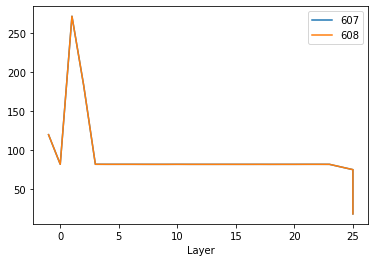

In [146]:
import matplotlib.pyplot as plt
weight_df_plot = weight_df[['Layer','607','608']]
weight_df_plot.set_index('Layer')
weight_df_plot.plot(x='Layer', y=['607','608']);

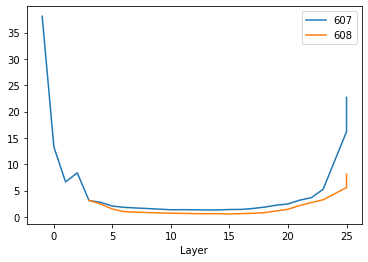

In [147]:
import matplotlib.pyplot as plt
grad_df_plot = grad_df[['Layer','607','608']]
grad_df_plot.set_index('Layer')
grad_df_plot.plot(x='Layer', y=['607','608']);

In [148]:
grad_df

,name,value,first_nan_idx,607,608,Layer
23,Train/grad_embedding_2norm,"[103.29421997070312, 103.53217315673828, 103.4...",608,38.097675,NaN,-1
24,Train/grad_layer_0_2norm,"[54.35948944091797, 54.52595138549805, 54.6853...",608,13.281496,NaN,0
25,Train/grad_layer_1_2norm,"[241.9202423095703, 243.14605712890625, 244.24...",608,6.631056,NaN,1
26,Train/grad_layer_2_2norm,"[167.96266174316406, 168.76881408691406, 169.7...",608,8.355430,NaN,2
3,Train/grad_layer_3_2norm,"[62.93558883666992, 63.19911575317383, 63.6056...",885,3.100649,3.145219,3
5,Train/grad_layer_4_2norm,"[63.615966796875, 63.90384292602539, 64.273933...",950,2.749049,2.426603,4
7,Train/grad_layer_5_2norm,"[62.18846893310547, 62.52492904663086, 62.8268...",1099,2.052094,1.478170,5
10,Train/grad_layer_6_2norm,"[61.07050704956055, 61.462486267089844, 61.727...",1099,1.801063,0.982004,6
11,Train/grad_layer_7_2norm,"[63.3437385559082, 63.75693130493164, 64.03693...",1099,1.680697,0.878587,7
12,Train/grad_layer_8_2norm,"[66.45199584960938, 66.84586334228516, 67.0798...",1099,1.578135,0.817214,8


In [142]:
weight_df_plot

,Layer,607,608
2,0,120.030708,120.033615
3,0,82.082260,82.081322
0,1,271.936127,271.931732
1,2,183.388824,183.385788
4,3,82.058441,82.057350
8,4,82.012581,82.011475
9,5,82.012695,82.011452
5,6,82.020607,82.019333
12,7,81.990829,81.989540
19,8,81.978439,81.977158
